In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

#Y_tau = sigma * torch.randn(64,64)
#print(Y_tau)

def gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        noise = torch.randn(image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, H):
    Y_tau = Y_0
    c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
    cov = np.zeros((image_size, image_size))
    for i in range(image_size):
        for j in range(image_size):
            cov[i][j] = c[abs(i - j)]
    inv_cov = np.linalg.inv(cov) 
    inv_covariance = torch.Tensor(inv_cov)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (2 * inv_covariance * Y_tau / sigma / sigma) + langevin_step_size * noise
    return Y_tau


def gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Y_0
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
    #print(beta_omega)
    for i in range(langevin_step_num):
        Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        #print(Y_tau.size())
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        #print(Y_ftau.size())
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        #print(Y_aftau.size())
        #print(i)
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau.data.numpy()
#def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
#    Y_tau = Y_0
#    omegat = range(image_size * image_size) 
#    omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
#    #beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
#    beta_omega = [xx ** beta / image_size / image_size for xx in omega]
#    beta_omega = torch.from_numpy(beta_omega)
#    print(beta_omega)
#    for i in range(langevin_step_num):
#        noise = torch.randn(image_size, image_size)
#        Y_ftau = torch.rfft(Y_tau ,2 ,onesided=False)
#        Y_aftau = torch.sqrt(Y_ftau[:,:,0]*Y_ftau[:,:,0]+Y_ftau[:,:,1]*Y_ftau[:,:,1])
#        #print(Y_aftau.shape)
#        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
#        (sum(beta_omega) * Y_tau / sigma / sigma) + langevin_step_size * noise
#        print(Y_tau)
#    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

In [2]:
import pylab as plt
langevin_step_size = 0.01
sigma = 10 
langevin_step_num = 2000
H = 0.9
beta = 0.1
image_size = 200

Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)
Y_u = 0.1 * sigma * torch.ones(image_size)

Y_out2 = gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
Y_out = gauss_omega_mcmc_simulate(Y_u ,langevin_step_size ,langevin_step_num ,sigma, image_size, H)
Y_out1 = gauss_omega_mcmc_simulate_omega(Y_u ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta)
#print(Y_out)


plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_out)
#plt.subplot(212)
plt.subplot(312)
plt.psd(Y_0)
plt.subplot(313)
plt.psd(Y_out1)

(array([5.72049132e+01, 3.96350153e+01, 1.52258529e-01, 5.02206648e-01,
        4.25633082e-03, 1.14803889e-01, 2.00379853e-01, 1.02421072e-01,
        1.82375191e-01, 1.70596657e-02, 4.18264609e-01, 3.78969279e-01,
        3.04031911e-01, 4.32566026e-01, 4.91133192e-02, 2.56980701e-01,
        5.86807655e-01, 1.28573187e-01, 8.86500485e-02, 2.51468855e-02,
        1.47016630e-01, 3.54252625e-02, 2.69373033e-03, 5.70579795e-02,
        1.76836990e-01, 3.70303439e-01, 3.73850917e-01, 1.04435318e-01,
        7.86078720e-02, 1.40371112e-01, 2.18988620e-01, 2.74629716e-01,
        1.61194091e-01, 1.47472774e-02, 7.21369649e-02, 1.90663006e-01,
        3.18345974e-01, 5.71507285e-01, 2.36697138e-01, 4.67471476e-02,
        1.32194713e-01, 1.35219269e-01, 8.77731643e-02, 2.95013640e-02,
        8.57727749e-02, 2.15016461e-02, 9.15292688e-02, 7.00408046e-02,
        1.78874649e-01, 5.26362212e-01, 3.52329977e-01, 1.29775195e-01,
        6.02868484e-02, 2.70733360e-03, 3.50842427e-02, 9.365314

(array([3.44743258e-07, 6.73370259e-07, 6.27200840e-07, 5.57077827e-07,
        4.71816165e-07, 3.81274530e-07, 2.94619104e-07, 2.18914700e-07,
        1.58320559e-07, 1.13989006e-07, 8.45781103e-08, 6.71491274e-08,
        5.81611661e-08, 5.43056199e-08, 5.30199638e-08, 5.26449018e-08,
        5.22980551e-08, 5.16002296e-08, 5.03958239e-08, 4.85670451e-08,
        4.59764655e-08, 4.25118131e-08, 3.81715807e-08, 3.31276983e-08,
        2.77259941e-08, 2.24212969e-08, 1.76748816e-08, 1.38558086e-08,
        1.11816805e-08, 9.71415798e-09, 9.40080437e-09, 1.01378589e-08,
        1.18243417e-08, 1.43863222e-08, 1.77659295e-08, 2.18853130e-08,
        2.66050461e-08, 3.16967641e-08, 3.68425033e-08, 4.16624072e-08,
        4.57628367e-08, 4.87916950e-08, 5.04876895e-08, 5.07139130e-08,
        4.94711531e-08, 4.68907343e-08, 4.32096419e-08, 3.87325128e-08,
        3.37866037e-08, 2.86774066e-08, 2.36536517e-08, 1.88897997e-08,
        1.44907172e-08, 1.05170585e-08, 7.02252037e-09, 4.088394

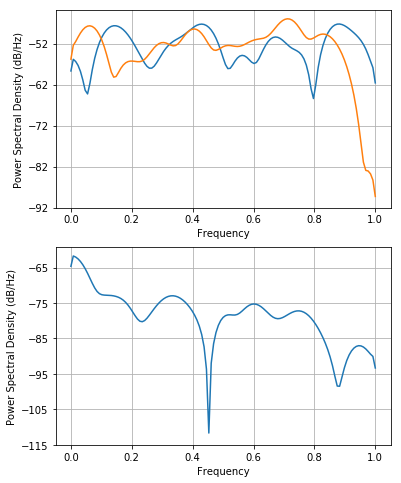

In [3]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 100
image_size = 32
Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)


Y_out = gauss_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(211)
plt.psd(Y_0)
#plt.subplot(212)
plt.psd(Y_out)
plt.subplot(212)
plt.psd(Y_u0)

In [4]:
import math
image_size =4
omegat = range(image_size * image_size) 
omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
beta = 0.1
beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
print(omega)
print(sum(beta_omega))
print(1/max(beta_omega))

[-1.5707963267948966, -1.3744467859455345, -1.1780972450961724, -0.9817477042468103, -0.7853981633974483, -0.5890486225480862, -0.39269908169872414, -0.19634954084936207, 0.0, 0.19634954084936207, 0.39269908169872414, 0.5890486225480862, 0.7853981633974483, 0.9817477042468103, 1.1780972450961724, 1.3744467859455345]
0.9069024508903286
15.293539001264099


In [5]:
import torch
import numpy as np
image_size = 4
H = 0.5
c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
print(c)
cov = np.zeros((image_size, image_size))
print(cov)
for i in range(image_size):
    for j in range(image_size):
        cov[i][j] = c[abs(i - j)]
print(cov)
inv_cov = np.linalg.inv(cov) 
print(inv_cov)
inv_covariance = torch.from_numpy(inv_cov)
print(inv_covariance)

[2.0, 0.0, 0.0, 0.0]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000]], dtype=torch.float64)


In [6]:
import torch
from torch.autograd import Variable
import math

x = Variable(torch.Tensor([2]), requires_grad=True)
y = x + 2
z = y ** 2 + 3
print(z)

z.backward()
print(x.grad)

sigma = 1
image_size = 8

beta = 0.5
omegat = range(image_size) 
print(omegat)
omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
print(omega)
beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
print(beta_omega.size())


Y_tau = Variable(0.1 * sigma * torch.ones(image_size), requires_grad=True)
print(Y_tau)
Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
print(Y_ftau)
Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
print(Y_aftau.size())
log_pY = -0.5 * Y_aftau.dot(beta_omega) 
print(log_pY)
log_pY.backward()
print(Y_tau.grad)
def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Variable(Y_0, requires_grad=True)
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
    print(beta_omega)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(Y_aftau.shape)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

tensor([19.], grad_fn=<AddBackward0>)
tensor([8.])
range(0, 8)
[-1.5707963267948966, -1.1780972450961724, -0.7853981633974483, -0.39269908169872414, 0.0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724]
torch.Size([8])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
       requires_grad=True)
tensor([[0.8000, 0.0000],
        [0.0000, -0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, -0.0000],
        [0.0000, -0.0000],
        [0.0000, 0.0000]], grad_fn=<SqueezeBackward1>)
torch.Size([8])
tensor(-0.0501, grad_fn=<MulBackward0>)
tensor([-0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253, -0.1253])


In [39]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

#log_pX = - beta1 * abs(X) - beta2 * X * X

def mcmc_simulate_beta(Y_0 ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        log_pY = (- beta1 * abs(Y_tau) - beta2 * Y_tau * Y_tau).sum()
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau.data.numpy()

langevin_step_size = 0.01  
langevin_step_num = 1000
image_size = 64
beta1 = 0.5
beta2 = 0.5
Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)
Y_u = 0.1 * sigma * torch.ones(image_size)


Y_o = mcmc_simulate_beta(Y_u ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2)
print(Y_o)

def mle_simulate_beta(Y_data, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size):
    beta1 = beta1_0
    beta2 = beta2_0
    for i in range(mle_step_num):
        Y_tuta = mcmc_simulate_beta(Y_tuta0, langevin_step_size, langevin_step_num, image_size, beta1, beta2)
        d_beta1 = ((-abs(Y_data).sum()) - (-abs(Y_tuta).sum())) / image_size
        d_beta2 = ((-(Y_data ** 2).sum()) - (-(Y_tuta ** 2).sum())) / image_size
        beta1 = beta1 - mle_step_size * d_beta1
        beta2 = beta2 - mle_step_size * d_beta2
        print(beta1,beta2)
    return beta1,beta2

Y_tuta0 = 0.1 * sigma * torch.ones(image_size)
beta1_0 = 0.4
beta2_0 = 0.4
mle_step_num = 500
mle_step_size = 0.002
langevin_step_num = 200
beta1_o,beta2_o = mle_simulate_beta(Y_o, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
print(beta1_o,beta2_o)

[ 0.46428093 -0.20930225  0.02386541 -0.22611555 -0.11013939  0.16297878
 -0.0206617  -0.1680557  -0.73691344  0.07446928  0.48653904  0.26388827
 -0.3896316  -0.23466016 -0.16123262 -0.05316342 -0.18768108  0.02490909
  0.2660881   0.09460855 -0.08104958  0.02147954  0.15077558  0.45895553
 -0.16727887  0.18456654 -0.26803055  0.45647717  0.18588074  0.8233547
  0.43462256  0.42123485 -0.12513784  0.25958246 -0.05008976 -0.03333287
 -0.04640293  0.10973714 -0.19805342  0.02797642  0.27341413  0.26740438
 -0.03654941  0.1745954  -0.376337    0.48206285 -0.05724792  0.2899318
 -0.2743842   0.1699352   0.3398347   0.30213377 -0.446983    0.31652415
  0.17084643  0.33327     0.29511675  0.11755254 -0.14823464  0.15100642
  0.3685791   0.27242103 -0.1413883  -0.20542735]
0.4001550716161728 0.40009016210585835
0.40033187270164494 0.4001862874403596
0.4005538737475873 0.40030028152465824
0.4007146016657353 0.4003960369378329
0.4009169944822789 0.40050850345194344
0.40111349567770965 0.400616

0.43777418720722205 0.42058990064263346
0.4379772993326188 0.42069408011436465
0.438165501177311 0.42080124213546516
0.4383756417930127 0.4209111822471023
0.43857403928041466 0.4210204477161169
0.43876584529876717 0.42112420781701804
0.43895612323284156 0.42122878358513116
0.4391627673506737 0.4213394379466772
0.4393654422461987 0.42145339692384004
0.4395592160820962 0.4215532485470176
0.439746763855219 0.42165526255220176
0.4399104766845704 0.4217536966353655
0.44007161957025537 0.4218406719863415
0.44024387565255174 0.4219386104643345
0.4404256116449834 0.4220386218875647
0.4406233162581922 0.4221445959359408
0.44083066293597234 0.4222516140043736
0.4409869762361051 0.42234666475653654
0.4411454197168352 0.42243747910857204
0.4413636517226698 0.42255328102409845
0.4415605390369894 0.42265859507024295
0.44166551953554173 0.42272729953378446
0.44189420053362866 0.4228452172279359
0.44213193538785 0.4229673924893142
0.44237267018854637 0.42309169955551634
0.44252957792580144 0.423181144

0.47982241131365333 0.44350988501310357
0.480040049389005 0.44362880361825235
0.480261275365949 0.4437456040754915
0.4804192451983693 0.44383415057510145
0.4806033387929204 0.44393156693130736
0.48078340779244927 0.44403576713055376
0.4809277826696637 0.4441226741820574
0.48109144867956666 0.44421933910250666
0.4812629997283223 0.4443174644261599
0.48149463979899915 0.4444371924698353
0.4817061943858865 0.4445497105196119
0.48186913056671654 0.44464380026608713
0.482075585201383 0.44475525148957973
0.4822358022481207 0.4448502239212394
0.4824718446284536 0.4449650958552957
0.4826496036499742 0.4450665361434222
0.4828532129079107 0.4451751146316529
0.48304011999070684 0.44527668505907064
0.4831977347582583 0.445367299348116
0.4833987741619353 0.44547136938571935
0.483593299582601 0.44558135277777916
0.48380426339805166 0.44569398521631964
0.4840260194092993 0.4458115130588413
0.4841882569640879 0.4458999787047506
0.4843553416877989 0.44599377276748425
0.4845320806056265 0.44609048338979